In [8]:
try:
    spark.stop()
except:
    pass

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType

spark = SparkSession.builder \
    .appName("APP_2") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .getOrCreate()

schema = StructType([
    StructField("userId", IntegerType(), True),
    StructField("movieId", IntegerType(), True),
    StructField("rating", FloatType(), True)
])
# Read ratings.csv
df = spark.read.csv("ratings.csv", header=True, schema = schema).cache()

In [3]:
print("Rows:", df.count())
print("Unique users:", df.select("userId").distinct().count())
print("Unique Movies:", df.select("movieId").distinct().count())

Rows: 32000204
Unique users: 200948
Unique Movies: 84432


In [4]:
# Select first n unique users
unique_users = df.select("userId").distinct().limit(1000)

# Keep only rows from these users
df = df.join(unique_users, on="userId", how="inner")

df.show(5)
print("Rows:", df.count())
print("Unique users:", df.select("userId").distinct().count())
print("Unique Movies:", df.select("movieId").distinct().count())

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|    28|      1|   4.0|
|    28|      2|   3.0|
|    28|      3|   4.0|
|    28|      5|   2.0|
|    28|      6|   3.0|
+------+-------+------+
only showing top 5 rows
Rows: 154972
Unique users: 1000
Unique Movies: 11459


In [5]:
n_users = df.select("userId").distinct().count()
n_movies = df.select("movieId").distinct().count()
n_ratings = df.count()

sparsity = (n_ratings / (n_users * n_movies)) * 100
print(f"Sparsity: {sparsity:.4f}%")

Sparsity: 1.3524%


In [6]:
from pyspark.sql.functions import col, round as spark_round
from pyspark.ml.feature import StringIndexer, VectorAssembler, MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.ml.functions import vector_to_array

user_indexer = StringIndexer(inputCol="userId", outputCol="user")
movie_indexer = StringIndexer(inputCol="movieId", outputCol="movie")
assembler = VectorAssembler(inputCols=["rating"], outputCol="rating_vec")
scaler = MinMaxScaler(inputCol="rating_vec", outputCol="rating_scaled")

pipeline = Pipeline(stages=[user_indexer, movie_indexer, assembler, scaler])

pipeline_model = pipeline.fit(df)
scaled_df = pipeline_model.transform(df)

# Flatten vector -> float, then round to 1 decimal
scaled_df = scaled_df.withColumn(
    "rating_scaled",
    spark_round(vector_to_array(col("rating_scaled"))[0], 1)
)

# Keep only necessary columns
df_final = scaled_df.select("user", "movie", "rating_scaled")
df_final = df_final.cache()
df_final.show(5)

+----+-----+-------------+
|user|movie|rating_scaled|
+----+-----+-------------+
| 0.0| 11.0|          0.8|
| 0.0|157.0|          0.6|
| 0.0|456.0|          0.8|
| 0.0|389.0|          0.3|
| 0.0|139.0|          0.6|
+----+-----+-------------+
only showing top 5 rows


In [7]:
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

In [8]:
import torch

# 80% train, 20% test
train_df, test_df = df_final.randomSplit([0.8, 0.2], seed=42)

#Converting PySpark DF to Pandas to Tensors
train_pd = train_df.toPandas()
test_pd = test_df.toPandas()

X_train = torch.tensor(train_pd[["user", "movie"]].values)
y_train = torch.tensor(train_pd["rating_scaled"].values)

X_test = torch.tensor(test_pd[["user", "movie"]].values)
y_test = torch.tensor(test_pd["rating_scaled"].values)

print("Train count:", X_train.shape[0])
print("Train Label:",y_train.shape[0])
print("Test count:", X_test.shape[0])
print("Test Label:",y_test.shape[0])

Train count: 123827
Train Label: 123827
Test count: 31145
Test Label: 31145


In [9]:
from torch.utils.data import TensorDataset, DataLoader

# Create datasets
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
#print(train_dataset[2200])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [10]:
import torch.nn as nn
import torch.nn.functional as F

class CollabFiltering(nn.Module):
    def __init__(self, n_users, n_movies, emb_dim, hidden, dropout):
        super().__init__()
        self.user_emb = nn.Embedding(n_users, emb_dim)   
        self.movie_emb = nn.Embedding(n_movies, emb_dim)  
        self.dropout_emb = 0.4

        self.mlp = nn.Sequential(
            nn.Linear(emb_dim * 2, hidden), 
            nn.BatchNorm1d(hidden),  
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, 1),  
            nn.Sigmoid()  
        )

    def forward(self,user,movie):
        u = F.dropout(self.user_emb(user), p=self.dropout_emb, training=self.training)
        m = F.dropout(self.movie_emb(movie), p=self.dropout_emb, training=self.training)
        
        # Concatenate embeddings (instead of dot product)
        x = torch.cat([u, m], dim=1)
        
        # Pass through MLP
        return self.mlp(x).squeeze()


In [11]:
loss_fn = nn.MSELoss()

In [12]:
def adam(parameter, m_state, v_state, t, lr=0.1, beta1=0.9, beta2=0.999, epsilon=1e-8):
    # Loop over Tensors in model.parameters()
    for p in parameter:
        if p.grad is None:
            continue

        # First Time seeing this parameter
        if p not in m_state:
            m_state[p] = torch.zeros_like(p)
            v_state[p] = torch.zeros_like(p)

        g = p.grad
        # First moment
        m_state[p] = beta1 * m_state[p] + (1 - beta1) * g
        # Second moment
        v_state[p] = beta2 * v_state[p] + (1 - beta2) * (g * g)

        # Bias correction
        m_corrected = m_state[p] / (1 - beta1 ** t)
        v_corrected = v_state[p] / (1 - beta2 ** t)

        # Parameter update (in-place)
        p.data -= lr * m_corrected / (torch.sqrt(v_corrected) + epsilon)

    return m_state, v_state



=== Training Node 1 ===
Node 1 | Epoch 1/10 | Train RMSE: 0.2226 | Test RMSE: 0.2105
Node 1 | Epoch 2/10 | Train RMSE: 0.2147 | Test RMSE: 0.2086
Node 1 | Epoch 3/10 | Train RMSE: 0.2130 | Test RMSE: 0.2090
Node 1 | Epoch 4/10 | Train RMSE: 0.2119 | Test RMSE: 0.2073
Node 1 | Epoch 5/10 | Train RMSE: 0.2113 | Test RMSE: 0.2069
Node 1 | Epoch 6/10 | Train RMSE: 0.2106 | Test RMSE: 0.2092
Node 1 | Epoch 7/10 | Train RMSE: 0.2101 | Test RMSE: 0.2083
Node 1 | Epoch 8/10 | Train RMSE: 0.2071 | Test RMSE: 0.2066
Node 1 | Epoch 9/10 | Train RMSE: 0.2048 | Test RMSE: 0.2090
Node 1 | Epoch 10/10 | Train RMSE: 0.2045 | Test RMSE: 0.2070

=== Training Node 2 ===
Node 2 | Epoch 1/10 | Train RMSE: 0.2234 | Test RMSE: 0.2142
Node 2 | Epoch 2/10 | Train RMSE: 0.2149 | Test RMSE: 0.2097
Node 2 | Epoch 3/10 | Train RMSE: 0.2129 | Test RMSE: 0.2113
Node 2 | Epoch 4/10 | Train RMSE: 0.2120 | Test RMSE: 0.2084
Node 2 | Epoch 5/10 | Train RMSE: 0.2116 | Test RMSE: 0.2094
Node 2 | Epoch 6/10 | Train RMSE: 

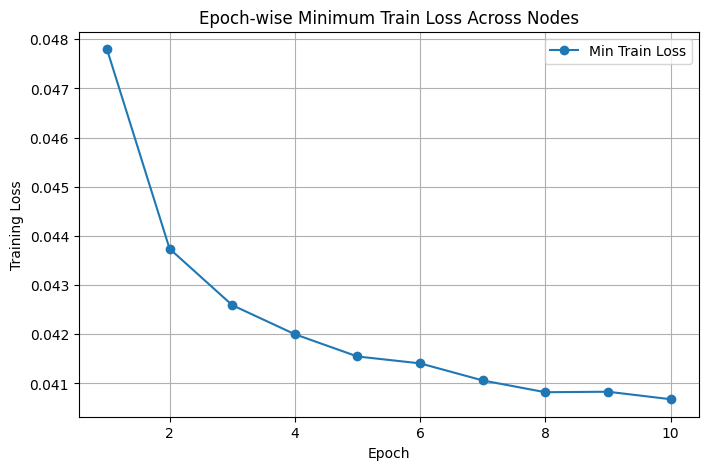

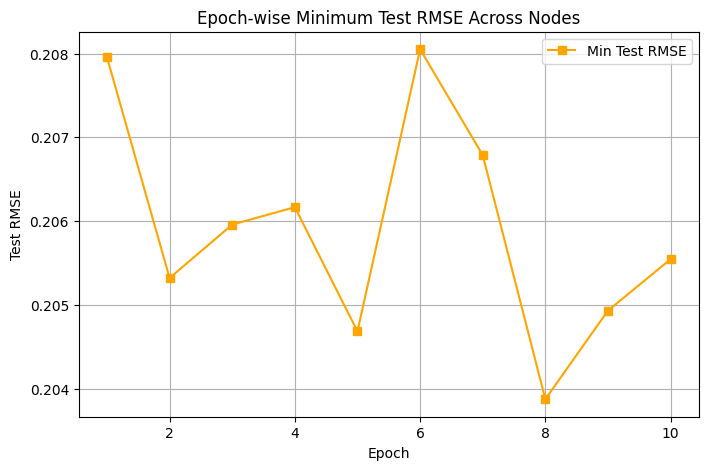

In [18]:
import copy
import matplotlib.pyplot as plt

# ---------- Settings ----------
epochs = 10
n_nodes = 5
all_nodes_stats = []         # store each node's per-epoch stats
min_train_curve = []         # aggregated min train loss per epoch
min_test_rmse_curve = []     # aggregated min test RMSE per epoch

n_users_global = df_final.select("user").distinct().count()
n_movies_global = df_final.select("movie").distinct().count()

# ---------- Train nodes ----------
for node_id in range(1, n_nodes + 1):
    print(f"\n=== Training Node {node_id} ===")
    node_model = CollabFiltering(n_users_global, n_movies_global, emb_dim=16, hidden=16, dropout=0.1)

    train_losses_epoch, test_losses_epoch = [], []
    train_rmses_epoch, test_rmses_epoch = [], []
    epoch_states = []

    # Adam states
    m_state, v_state, t = {}, {}, 0

    for epoch in range(epochs):
        # ---------- Training ----------
        node_model.train()
        total_loss, total_sq_error, total_samples = 0, 0, 0
        for X_batch, y_batch in train_loader:
            preds = node_model(X_batch[:, 0].long(), X_batch[:, 1].long()).squeeze()
            loss = loss_fn(preds, y_batch.float())
            node_model.zero_grad()
            loss.backward()
            t += 1

            # ---------- Adam optimizer step ----------
            m_state, v_state = adam(node_model.parameters(), m_state, v_state, t)

            total_loss += loss.item()
            total_sq_error += torch.sum((preds - y_batch)**2).item()
            total_samples += len(y_batch)

        train_loss = total_loss / len(train_loader)
        train_rmse = (total_sq_error / total_samples)**0.5

        # ---------- Testing ----------
        node_model.eval()
        total_loss, total_sq_error, total_samples = 0, 0, 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                preds = node_model(X_batch[:, 0].long(), X_batch[:, 1].long()).squeeze()
                loss = loss_fn(preds, y_batch.float())
                total_loss += loss.item()
                total_sq_error += torch.sum((preds - y_batch)**2).item()
                total_samples += len(y_batch)

        test_loss = total_loss / len(test_loader)
        test_rmse = (total_sq_error / total_samples)**0.5

        # ---------- Save per-epoch stats ----------
        train_losses_epoch.append(train_loss)
        test_losses_epoch.append(test_loss)
        train_rmses_epoch.append(train_rmse)
        test_rmses_epoch.append(test_rmse)
        epoch_states.append(copy.deepcopy(node_model.state_dict()))

        print(f"Node {node_id} | Epoch {epoch+1}/{epochs} | "
              f"Train RMSE: {train_rmse:.4f} | Test RMSE: {test_rmse:.4f}")

    # ---------- Store node info ----------
    all_nodes_stats.append({
        "node": node_id,
        "train_losses": train_losses_epoch,
        "test_losses": test_losses_epoch,
        "train_rmses": train_rmses_epoch,
        "test_rmses": test_rmses_epoch,
        "epoch_states": epoch_states
    })

# ---------- Aggregation (MIN across nodes for each epoch) ----------
for epoch in range(epochs):
    min_train_curve.append(min(node["train_losses"][epoch] for node in all_nodes_stats))
    min_test_rmse_curve.append(min(node["test_rmses"][epoch] for node in all_nodes_stats))

# ---------- Plot Minimum Train Loss ----------
plt.figure(figsize=(8,5))
plt.plot(range(1, epochs+1), min_train_curve, marker='o', label="Min Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Epoch-wise Minimum Train Loss Across Nodes")
plt.legend()
plt.grid(True)
plt.show()

# ---------- Plot Minimum Test RMSE ----------
plt.figure(figsize=(8,5))
plt.plot(range(1, epochs+1), min_test_rmse_curve, marker='s', color='orange', label="Min Test RMSE")
plt.xlabel("Epoch")
plt.ylabel("Test RMSE")
plt.title("Epoch-wise Minimum Test RMSE Across Nodes")
plt.legend()
plt.grid(True)
plt.show()



In [19]:
import utils

metrics = {
    "min_train_curve": min_train_curve,
    "min_test_rmse_curve": min_test_rmse_curve
}

# Save the Base approach results
utils.save_results("results/epoch_split.pkl", metrics)
